# linear regreesion（线性回归）

In [171]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set(context='notebook', style='whitegrid', palette='dark')

In [172]:
df = pd.read_csv('./ex1data1.txt', names=['population', 'profit'])
df.head()

,population,profit
0,6.1101,17.5920
1,5.5277,9.1302
2,8.5186,13.6620
3,7.0032,11.8540
4,5.8598,6.8233


In [173]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 2 columns):
population    97 non-null float64
profit        97 non-null float64
dtypes: float64(2)
memory usage: 1.6 KB


#### lmplot是用来绘制回归图的，通过lmplot我们可以直观地总览数据的内在关系
`http://seaborn.pydata.org/generated/seaborn.lmplot.html`

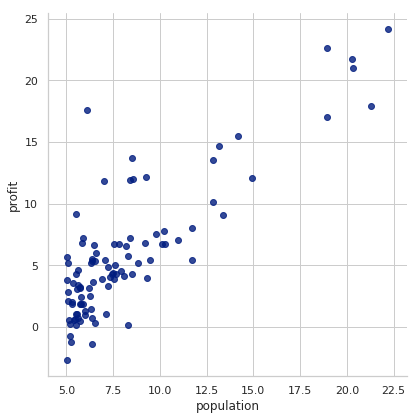

In [174]:
sns.lmplot('population', 'profit', df, size=6, fit_reg=False)
plt.show()

In [175]:
def get_X(df):
    # 读取特征
    ones_df = pd.DataFrame(np.ones(len(df)))
    df = pd.concat([ones_df, df], axis=1)
    # 这里返回的是ndarray
    return df.iloc[:, :-1].values

def get_y(df):
    # 获取y的实际值
    return df.iloc[:, -1].values

def normalize_feature(df):
    # 特征缩放  numpy 的标准差是算的样本标准差，即除数为总数-1
    return df.apply(lambda column: (column - column.mead()/column.std()))

In [176]:
def linear_regression1(X_data, y_data, alpha, epoch, optimizer=tf.train.GradientDescentOptimizer): 
    # 图形输入的占位符
    
    tf.reset_default_graph()
    
    X = tf.placeholder(tf.float32, shape=X_data.shape)
    y = tf.placeholder(tf.float32, shape=y_data.shape)
    
    # 构照图
    with tf.variable_scope('linear-regression'):
        W = tf.get_variable('weights', 
                           (X_data.shape[1], 1),
                           initializer=tf.constant_initializer())  # n *１
        
        y_pred = tf.matmul(X, W)  # m*n @ n*1 -> m*1
        loss = 1 / (2*len(X_data)) * tf.matmul((y_pred - y), (y_pred -y), transpose_a=True)  # (m*1).T @ m*1 = 1*1
    opt = optimizer(learning_rate=alpha)
    opt_operation = opt.minimize(loss)
    
    # run the session
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        loss_data = []
        for i in range(epoch):
            _, loss_var, W_val = sess.run([opt_operation, loss, W], feed_dict = {X:X_data,y:y_data})
            loss_data.append(loss_var[0, 0])  # loss_var 是 1*1 ndarray

            if len(loss_data) > 1 and np.abs(loss_data[-1] - loss_data[-2]) < 10 ** -9:# 默认为已经收敛
                break
    
    # 清理图像
    tf.reset_default_graph()
    return {'loss': loss_data, 'parameters': W_val}


In [177]:
data = pd.read_csv('ex1data1.txt', names=['population', 'profit'])
data.head()

,population,profit
0,6.1101,17.5920
1,5.5277,9.1302
2,8.5186,13.6620
3,7.0032,11.8540
4,5.8598,6.8233


### 计算代价函数

In [178]:
X = get_X(data)
print(X.shape, type(X))
print('*' * 50)
y = get_y(data)
print(y.shape, type(y))

(97, 2) <class 'numpy.ndarray'>
**************************************************
(97,) <class 'numpy.ndarray'>


In [179]:
theta = np.zeros(X.shape[1])  # 代表了特征数量  2
print(theta)

[0. 0.]


In [180]:
def lr_cost(theta, X, y):
#     """
#     X: R(m*n), m 样本数, n 特征数
#     y: R(m)
#     theta : R(n), 线性回归的参数
#     """

    m = X.shape[0]  # 样本数量
    
    # X @ theta为预测值，再减去y过后就是预测值与真实值之前的误差，即预测误差
    inner = X @ theta - y  # R(m*1)，X @ theta等价于X.dot(theta)
    
    # 1*m @ m*1 = 1*1 in matrix multiplication
    # but you know numpy didn't do transpose in 1d array, so here is just a
    # vector inner product to itselves
    square_sum = inner.T @ inner  # 这里相当于是算误差的平方
    cost = square_sum / (2 * m)
    cost = np.nan_to_num(cost)
    
    return cost 

In [181]:
lr_cost(theta, X, y)

32.072733877455676

batch gradient decent（批量梯度下降）¶
$${{\theta }_{j}}:={{\theta }_{j}}-\alpha \frac{\partial }{\partial {{\theta }_{j}}}J\left( \theta  \right)$$

tensorflow-梯度下降,有这一篇就足够了:
https://segmentfault.com/a/1190000011994447

In [182]:
def gradient(theta, X, y):
    m = X.shape[0]
    
    # 代价函数的导数，这里把X放到前面去了，所需需要转置，即X.T
    cost = X.T @ (X @ theta - y)  # (m,n).T @ (m, 1) -> (n, 1)，X @ theta等价于X.dot(theta)

    cost = np.nan_to_num(cost)
     
    return cost / m

In [183]:
def batch_gradient_decent(theta, X, y, epoch, alpha=0.01):
#  批量梯度下降函数
#   拟合线性回归，返回参数和代价
#     epoch: 批处理的轮数
#     """
    cost_data = [lr_cost(theta, X, y)]
    
    # 拷贝一份，不和原来的theta混淆
    _theta = theta.copy()
    
    for _ in range(epoch):
        _theta = _theta - alpha * gradient(_theta, X, y)
#         print(_theta)
        cost_data.append(lr_cost(_theta, X, y))
        
    return _theta, cost_data


In [184]:
epoch = 500
final_theta, cost_data = batch_gradient_decent(theta, X, y, epoch)

In [185]:
final_theta, cost_data

(array([-2.28286727,  1.03099898]),
 [32.072733877455676,
  6.737190464870011,
  5.931593568604956,
  5.90115470708139,
  5.895228586444221,
  5.8900949431173295,
  5.885004158443647,
  5.8799324804914175,
  5.874879094762575,
  5.869843911806385,
  5.8648268653129305,
  5.8598278899321805,
  5.85484692057229,
  5.849883892376587,
  5.844938740722034,
  5.840011401218361,
  5.8351018097072265,
  5.830209902261389,
  5.825335615183863,
  5.820478885007098,
  5.815639648492152,
  5.81081784262787,
  5.806013404630045,
  5.801226271940628,
  5.7964563822269,
  5.7917036733806535,
  5.786968083517396,
  5.782249550975539,
  5.777548014315596,
  5.772863412319381,
  5.768195683989214,
  5.76354476854712,
  5.758910605434049,
  5.754293134309078,
  5.749692295048629,
  5.745108027745684,
  5.740540272709012,
  5.735988970462381,
  5.731454061743792,
  5.7269354875047,
  5.722433188909257,
  5.717947107333528,
  5.713477184364749,
  5.709023361800549,
  5.704585581648199,
  5.700163786123857,

In [186]:
# 计算最终的代价函数
lr_cost(final_theta, X, y)

4.713809531116867

### visualize cost data(可视化代价函数值)

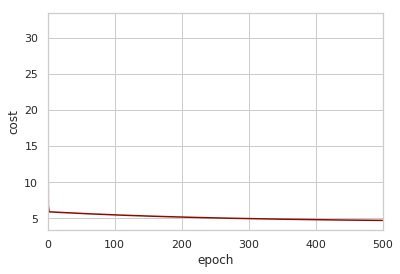

In [187]:
ax = sns.tsplot(cost_data, time=np.arange(epoch+1), color = 'r' )
ax.set_xlabel('epoch')
ax.set_ylabel('cost')
plt.show()
# 这里看不到epoch=0时的数据，奇怪

In [188]:
help(sns.tsplot)

Help on function tsplot in module seaborn.timeseries:

tsplot(data, time=None, unit=None, condition=None, value=None, err_style='ci_band', ci=68, interpolate=True, color=None, estimator=<function mean at 0x7fc8d41ee268>, n_boot=5000, err_palette=None, err_kws=None, legend=True, ax=None, **kwargs)
    Plot one or more timeseries with flexible representation of uncertainty.
    
    This function is intended to be used with data where observations are
    nested within sampling units that were measured at multiple timepoints.
    
    It can take data specified either as a long-form (tidy) DataFrame or as an
    ndarray with dimensions (unit, time) The interpretation of some of the
    other parameters changes depending on the type of object passed as data.
    
    Parameters
    ----------
    data : DataFrame or ndarray
        Data for the plot. Should either be a "long form" dataframe or an
        array with dimensions (unit, time, condition). In both cases, the
        condition f

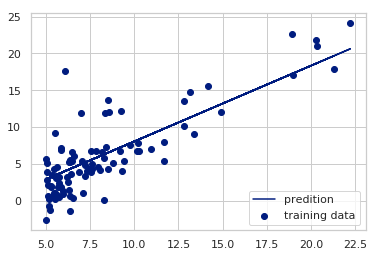

In [189]:
b = final_theta[0]  # intercept，Y轴上的截距
w = final_theta[1]  # slope，斜率

plt.scatter(data.population, data.profit, label='training data')
plt.plot(data.population, w*data.population+b, label='predition')
# plt.legend（）函数主要的作用就是给图加上图例，plt.legend([x,y,z])里面的参数使用的是list的的形式将图表的的名称喂给这和函数。
# loc的作用是确定图例的位置
plt.legend(loc=4)
plt.show()

In [190]:
raw_data = pd.read_csv('ex1data2.txt', names=['square', 'bedrooms', 'price'])
raw_data.head()

,square,bedrooms,price
0,2104,3,399900
1,1600,3,329900
2,2400,3,369000
3,1416,2,232000
4,3000,4,539900


标准化数据,
最简单的方法是令：
特征缩放

In [191]:
def normalize_feature(df):
    return df.apply(lambda column: (column - column.mean())/ column.std())

In [192]:
data1 = normalize_feature(raw_data)
data1.head()

,square,bedrooms,price
0,0.130010,-0.223675,0.475747
1,-0.504190,-0.223675,-0.084074
2,0.502476,-0.223675,0.228626
3,-0.735723,-1.537767,-0.867025
4,1.257476,1.090417,1.595389


 multi-var batch gradient decent（多变量批量梯度下降）

In [193]:
X = get_X(data1)
print(X.shape)
y = get_y(data1)
print(y.shape)

(47, 3)
(47,)


In [194]:
alpha = 0.01
epoch = 500
theta = np.zeros(X.shape[1])

In [195]:
theta

array([0., 0., 0.])

In [196]:
final_theta, cost_data = batch_gradient_decent(theta, X, y, epoch, alpha=alpha)

In [197]:
final_theta, cost_data

(array([-1.16880501e-16,  8.30383883e-01,  8.23982853e-04]),
 [0.4893617021276595,
  0.4805491041076718,
  0.4719858770120386,
  0.4636646161870627,
  0.4555781400525299,
  0.44771948335326117,
  0.4400818906150644,
  0.43265880979889004,
  0.42544388614718714,
  0.4184309562166347,
  0.4116140420916036,
  0.4049873457728716,
  0.39854524373628336,
  0.3922822816562034,
  0.3861931692887743,
  0.3802727755101313,
  0.37451612350488717,
  0.3689183861003258,
  0.36347488124189703,
  0.35818106760572727,
  0.35303254034399595,
  0.34802502695915444,
  0.3431543833030802,
  0.3384165896973838,
  0.3338077471711977,
  0.3293240738128864,
  0.32496190123222946,
  0.32071767112972555,
  0.3165879319697777,
  0.31256933575460877,
  0.30865863489585715,
  0.3048526791808924,
  0.30114841283098287,
  0.29754287164853044,
  0.2940331802506764,
  0.290616549386659,
  0.28729027333638907,
  0.28405172738778045,
  0.28089836539044943,
  0.2778277173834725,
  0.2748373872949541,
  0.2719250507112348

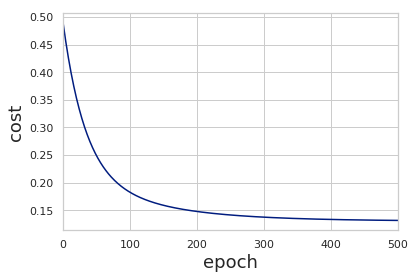

In [198]:
sns.tsplot(time=np.arange(len(cost_data)), data = cost_data)
plt.xlabel('epoch', fontsize=18)
plt.ylabel('cost', fontsize=18)
plt.show()

### learning rate（学习率）

In [199]:
# logspace创建等比数列
base = np.logspace(-1, -5, num=4)
# numpy提供了numpy.concatenate((a1,a2,...), axis=0)函数。能够一次完成多个数组的拼接。其中a1,a2,...是数组类型的参数
candidate = np.sort(np.concatenate((base, base*3)))
print(candicate)

[1.00000000e-05 3.00000000e-05 2.15443469e-04 6.46330407e-04
 4.64158883e-03 1.39247665e-02 1.00000000e-01 3.00000000e-01]


plt.subplots概述：https://blog.csdn.net/qq_39622065/article/details/82909421

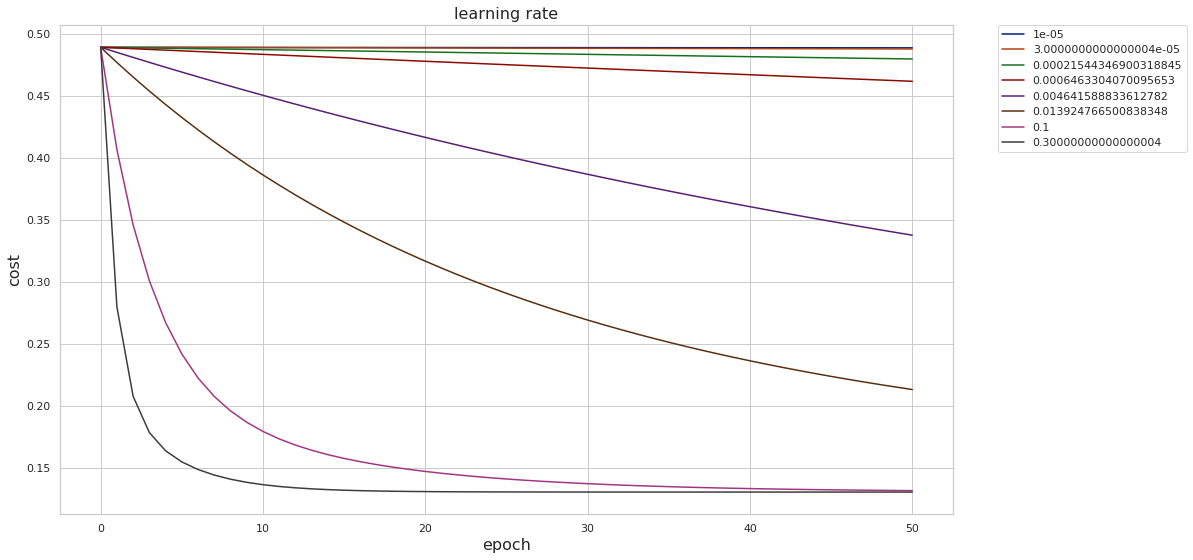

In [200]:
epoch = 50
figure, ax = plt.subplots(figsize=(16, 9))  # 设置图像的大小

for alpha in candicate:
    _, cost_data = batch_gradient_decent(theta, X, y, epoch, alpha=alpha)
    ax.plot(np.arange(epoch+1), cost_data, label=alpha)
    
ax.set_xlabel('epoch', fontsize=16)
ax.set_ylabel('cost', fontsize=16)

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_title('learning rate', fontsize=16)
plt.show()


4. normal equation（正规方程）
正规方程是通过求解下面的方程来找出使得代价函数最小的参数的：$\frac{\partial }{\partial {{\theta }_{j}}}J\left( {{\theta }_{j}} \right)=0$ 。 假设我们的训练集特征矩阵为 X（包含了${{x}_{0}}=1$）并且我们的训练集结果为向量 y，则利用正规方程解出向量 $\theta ={{\left( {{X}^{T}}X \right)}^{-1}}{{X}^{T}}y$ 。 上标T代表矩阵转置，上标-1 代表矩阵的逆。设矩阵$A={{X}^{T}}X$，则：${{\left( {{X}^{T}}X \right)}^{-1}}={{A}^{-1}}$

梯度下降与正规方程的比较：

梯度下降：需要选择学习率α，需要多次迭代，当特征数量n大时也能较好适用，适用于各种类型的模型

正规方程：不需要选择学习率α，一次计算得出，需要计算${{\left( {{X}^{T}}X \right)}^{-1}}$，如果特征数量n较大则运算代价大，因为矩阵逆的计算时间复杂度为O(n3)，通常来说当n小于10000 时还是可以接受的，只适用于线性模型，不适合逻辑回归模型等其他模型

In [201]:
def normalEqn(X, y):
    # 正规方程
    theta = np.linalg.inv(X.T@X)@X.T@y  # X.T@X等价于X.T.dot(X)
    theta = np.nan_to_num(theta)
    return theta


In [202]:
final_theta2 = normalEqn(X, y)
print(final_theta2)

[-6.93889390e-17  8.84765988e-01 -5.31788197e-02]


In [203]:
X_data = get_X(data1)
# print(X_data)

# 特殊处理为了作为TensorFlow的输入数据
y_data = get_y(data1).reshape(len(X_data), 1)
# print(y_data)


In [204]:
epoch = 2000
alpha = 0.01

In [205]:
optimizer_dict={'GD': tf.train.GradientDescentOptimizer,
                'Adagrad': tf.train.AdagradOptimizer,
                'Adam': tf.train.AdamOptimizer,
                'Ftrl': tf.train.FtrlOptimizer,
                'RMS': tf.train.RMSPropOptimizer
               }
results = []
for name in optimizer_dict:
    res = linear_regression(X_data, y_data, alpha, epoch, optimizer=optimizer_dict[name])
    res['name'] = name
    results.append(res)
    

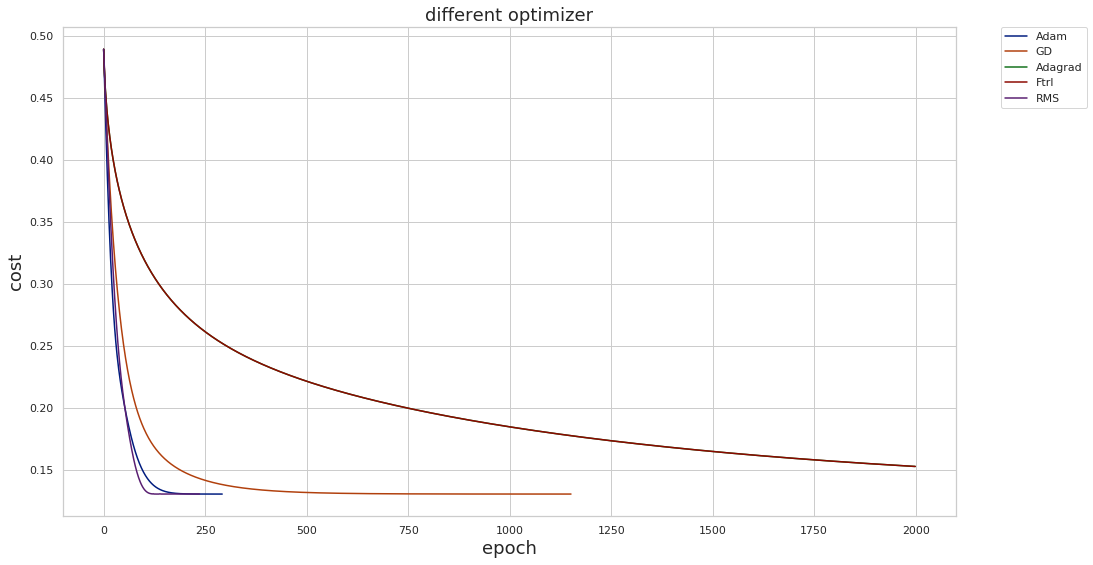

In [207]:
fig, ax = plt.subplots(figsize=(16, 9))

for res in results: 
    loss_data = res['loss']
    
#     print('for optimizer {}'.format(res['name']))
#     print('final parameters\n', res['parameters'])
#     print('final loss={}\n'.format(loss_data[-1]))
    ax.plot(np.arange(len(loss_data)), loss_data, label=res['name'])

ax.set_xlabel('epoch', fontsize=18)
ax.set_ylabel('cost', fontsize=18)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_title('different optimizer', fontsize=18)
plt.show()
